In [26]:
try:
    from PIL import Image
except ImportError:
    import Image
import matplotlib.pyplot as plt

import subprocess
import imutils
import shutil
import cv2
import os

In [27]:
import pytesseract


import easyocr
reader = easyocr.Reader(['en'])


from paddleocr import PaddleOCR, draw_ocr
ocr = PaddleOCR(lang='en')

Namespace(cls_batch_num=30, cls_image_shape='3, 48, 192', cls_model_dir='/home/ihor/.paddleocr/2.0/cls', cls_thresh=0.9, det=True, det_algorithm='DB', det_db_box_thresh=0.5, det_db_thresh=0.3, det_db_unclip_ratio=2.0, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/ihor/.paddleocr/2.0/det', drop_score=0.5, enable_mkldnn=False, gpu_mem=8000, image_dir='', ir_optim=True, label_list=['0', '180'], lang='en', max_text_length=25, rec=True, rec_algorithm='CRNN', rec_batch_num=30, rec_char_dict_path='./ppocr/utils/dict/en_dict.txt', rec_char_type='ch', rec_image_shape='3, 32, 320', rec_model_dir='/home/ihor/.paddleocr/2.0/rec/en', use_angle_cls=False, use_gpu=True, use_pdserving=False, use_space_char=True, use_tensorrt=False, use_zero_copy_run=False)


In [28]:
def preproccesing(img):
    image = imutils.resize(img, width=800)
    image = cv2.GaussianBlur(image, (5,5), 0)
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    result = 255 - image
    return result

In [29]:
labels = {
    0: 'label',
    1: 'price',
    2: 'cop',
    3: 'name',
    4: 'barcode'
}

labels_to_show = {
#     0: 'label',
    1: 'price',
    2: 'cop',
    3: 'name',
#     4: 'barcode'
}

In [30]:
images_gen = iter(os.listdir('images/'))

In [36]:
image_name = next(images_gen)

In [37]:
try:
    shutil.rmtree('runs/detect/')
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))

process = subprocess.run(['python3', 'detect.py', 
                          '--weights', 'weights/best.pt', 
                          '--img', '1024',
                          '--conf', '0.45',
                          '--source', 'images/' + image_name,
                          '--save-txt'],
                                        check=False,
                                        capture_output=True,  
                                        universal_newlines=True)

### Tesseract

cop:
h ()
________________
price:
Wi
________________
name:
JABON 528
RICITOS DE
ORO 100 GRS
________________


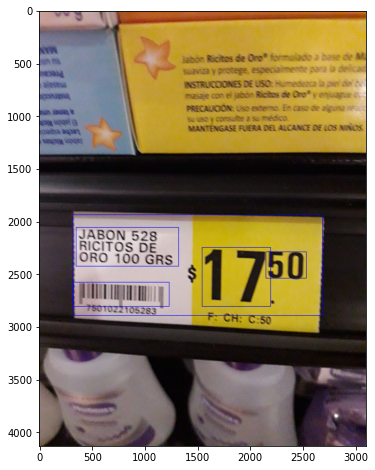

CPU times: user 1.24 s, sys: 161 ms, total: 1.4 s
Wall time: 1.74 s


In [38]:
%%time
img = cv2.imread('images/' + image_name)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

dh, dw = gray.shape
fl = open("runs/detect/exp/labels/" + os.path.splitext(image_name)[0] + '.txt', 'r')
data = fl.readlines()
fl.close()

for dt in data:

    l, x, y, w, h = map(float, dt.split(' '))

    x1 = int((x - w / 2) * dw)
    x2 = int((x + w / 2) * dw)
    y1 = int((y - h / 2) * dh)
    y2 = int((y + h / 2) * dh)
    
    field = labels.get(int(l))
    if labels_to_show.get(int(l)):
        
        crop_img = gray[y1:y2, x1:x2]
        
        text = pytesseract.image_to_string(preproccesing(crop_img), lang='eng', config="--psm 6")
        print(field + ':')
        print(text.strip())
        print('________________')


    if x1 < 0:
        x1 = 0
    if x2 > dw - 1:
        x2 = dw - 1
    if y1 < 0:
        y1 = 0
    if y2 > dh - 1:
        y2 = dh - 1

    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
plt.figure(figsize=(16,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Easy OCR

cop:
50
________________
price:
Empty field
________________
name:
JABON
________________


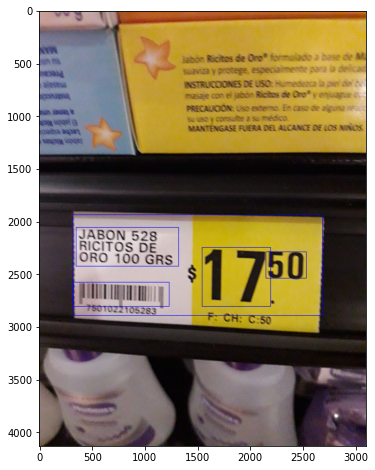

CPU times: user 1.49 s, sys: 137 ms, total: 1.63 s
Wall time: 1.57 s


In [39]:
%%time
img = cv2.imread('images/' + image_name)
dh, dw, _ = img.shape

fl = open("runs/detect/exp/labels/" + os.path.splitext(image_name)[0] + '.txt', 'r')
data = fl.readlines()
fl.close()

for dt in data:

    l, x, y, w, h = map(float, dt.split(' '))

    x1 = int((x - w / 2) * dw)
    x2 = int((x + w / 2) * dw)
    y1 = int((y - h / 2) * dh)
    y2 = int((y + h / 2) * dh)
    
    field = labels.get(int(l))
    if labels_to_show.get(int(l)):
        
        crop_img = img[y1:y2, x1:x2]
        result = reader.readtext(crop_img)
        try:
            text = result[0][1]
            print(field + ':')
            print(text.strip())
            print('________________')
        except:
            print(field + ':')
            print('Empty field')
            print('________________')

    if x1 < 0:
        x1 = 0
    if x2 > dw - 1:
        x2 = dw - 1
    if y1 < 0:
        y1 = 0
    if y2 > dh - 1:
        y2 = dh - 1

    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
plt.figure(figsize=(16,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Paddle OCR

cop:
50
________________
price:
1
________________
name:
SES
________________


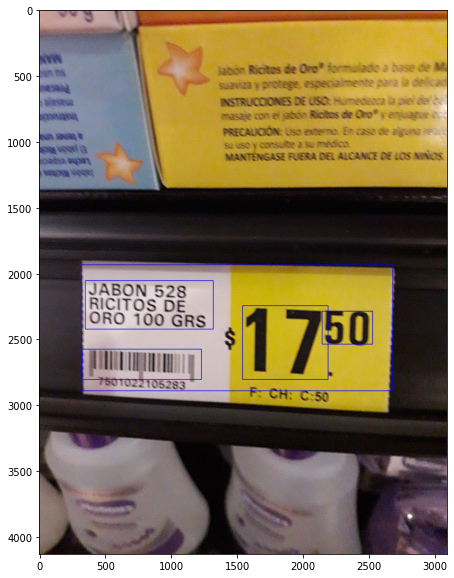

CPU times: user 1.25 s, sys: 106 ms, total: 1.36 s
Wall time: 1.31 s


In [40]:
%%time
img = cv2.imread('images/' + image_name)
dh, dw, _ = img.shape

fl = open("runs/detect/exp/labels/" + os.path.splitext(image_name)[0] + '.txt', 'r')
data = fl.readlines()
fl.close()

for dt in data:

    l, x, y, w, h = map(float, dt.split(' '))

    x1 = int((x - w / 2) * dw)
    x2 = int((x + w / 2) * dw)
    y1 = int((y - h / 2) * dh)
    y2 = int((y + h / 2) * dh)
    
    field = labels.get(int(l))
    if labels_to_show.get(int(l)):    
        crop_img = img[y1:y2, x1:x2]
        result = ocr.ocr(crop_img, det=False, cls=False)
        try:
            text = result[0][0]
            print(field + ':')
            print(text.strip())
            print('________________')
        except:
            print(field + ':')
            print('Empty field')
            print('________________')

    if x1 < 0:
        x1 = 0
    if x2 > dw - 1:
        x2 = dw - 1
    if y1 < 0:
        y1 = 0
    if y2 > dh - 1:
        y2 = dh - 1

    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

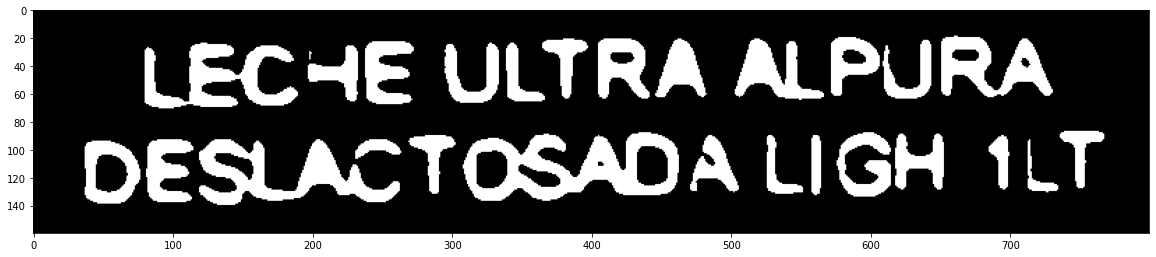

In [19]:
def preproccesing(img):
    image = imutils.resize(img, width=800)
    image = cv2.GaussianBlur(image, (5,5), 0)
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    result = 255 - image
    return result

img = cv2.imread('sample/name.png', 0)
prep_img = preproccesing(img)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(prep_img, cv2.COLOR_BGR2RGB))
plt.show()

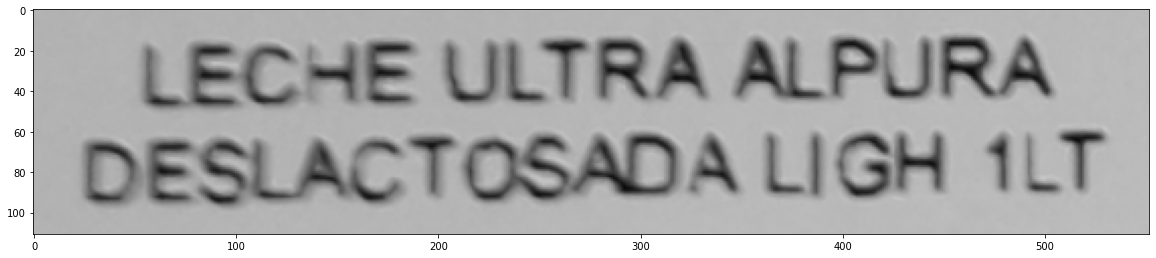

In [58]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()